In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/global-earthquake-tsunami-risk-assessment-dataset/earthquake_data_tsunami.csv


Feature 	Type 	Description 	Range/Values 	Tsunami Relevance
magnitude 	Float 	Earthquake magnitude (Richter scale) 	6.5 - 9.1 	High - Primary tsunami predictor

cdi 	Integer 	Community Decimal Intensity (felt intensity) 	0 - 9 	Medium - Population impact measure

mmi 	Integer 	Modified Mercalli Intensity (instrumental) 	1 - 9 	Medium - Structural damage indicator

sig 	Integer 	Event significance score 	650 - 2910 	High - Overall hazard assessment

nst 	Integer 	Number of seismic monitoring stations 	0 - 934 	Low - Data quality indicator

dmin 	Float 	Distance to nearest seismic station (degrees) 	0.0 - 17.7 	Low - Location precision

gap 	Float 	Azimuthal gap between stations (degrees) 	0.0 - 239.0 	Low - Location reliability

depth 	Float 	Earthquake focal depth (km) 	2.7 - 670.8 	High - Shallow = higher tsunami risk

latitude 	Float 	Epicenter latitude (WGS84) 	-61.85° to 71.63° 	High - Ocean proximity indicator

longitude 	Float 	Epicenter longitude (WGS84) 	-179.97° to 179.66° 	High - Ocean proximity indicator

Year 	Integer 	Year of occurrence 	2001 - 2022 	Medium - Temporal patterns

Month 	Integer 	Month of occurrence 	1 - 12 	Low - Seasonal analysis

tsunami 	Binary 	Tsunami potential (TARGET) 	0, 1 	TARGET VARIABLE

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay


import folium

In [3]:
earthquake = pd.read_csv('/kaggle/input/global-earthquake-tsunami-risk-assessment-dataset/earthquake_data_tsunami.csv')
earthquake.head()

,magnitude,cdi,mmi,sig,nst,dmin,gap,depth,latitude,longitude,Year,Month,tsunami
0,7.0,8,7,768,117,0.509,17.0,14.000,-9.7963,159.596,2022,11,1
1,6.9,4,4,735,99,2.229,34.0,25.000,-4.9559,100.738,2022,11,0
2,7.0,3,3,755,147,3.125,18.0,579.000,-20.0508,-178.346,2022,11,1
3,7.3,5,5,833,149,1.865,21.0,37.000,-19.2918,-172.129,2022,11,1
4,6.6,0,2,670,131,4.998,27.0,624.464,-25.5948,178.278,2022,11,1


In [4]:
earthquake.describe()

,magnitude,cdi,mmi,sig,nst,dmin,gap,depth,latitude,longitude,Year,Month,tsunami
count,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000
mean,6.941125,4.333760,5.964194,870.108696,230.250639,1.325757,25.038990,75.883199,3.538100,52.609199,2012.280051,6.563939,0.388747
std,0.445514,3.169939,1.462724,322.465367,250.188177,2.218805,24.225067,137.277078,27.303429,117.898886,6.099439,3.507866,0.487778
min,6.500000,0.000000,1.000000,650.000000,0.000000,0.000000,0.000000,2.700000,-61.848400,-179.968000,2001.000000,1.000000,0.000000
25%,6.600000,0.000000,5.000000,691.000000,0.000000,0.000000,14.625000,14.000000,-14.595600,-71.668050,2007.000000,3.250000,0.000000
50%,6.800000,5.000000,6.000000,754.000000,140.000000,0.000000,20.000000,26.295000,-2.572500,109.426000,2013.000000,7.000000,0.000000
75%,7.100000,7.000000,7.000000,909.750000,445.000000,1.863000,30.000000,49.750000,24.654500,148.941000,2017.000000,10.000000,1.000000
max,9.100000,9.000000,9.000000,2910.000000,934.000000,17.654000,239.000000,670.810000,71.631200,179.662000,2022.000000,12.000000,1.000000


In [5]:
earthquake.isna().sum()

magnitude    0
cdi          0
mmi          0
sig          0
nst          0
dmin         0
gap          0
depth        0
latitude     0
longitude    0
Year         0
Month        0
tsunami      0
dtype: int64

In [11]:
# Center the map on the average coordinates
lat_center = earthquake['latitude'].mean()
lon_center = earthquake['longitude'].mean()

# Initialize the map
m = folium.Map(location=[lat_center, lon_center], zoom_start=2)

# Add earthquake points
for idx, row in earthquake.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=row['magnitude']*2,  # size proportional to magnitude
        color='red' if row['tsunami'] == 1 else 'blue',  # red if tsunami, else blue
        fill=True,
        fill_color='red' if row['tsunami'] == 1 else 'blue',
        fill_opacity=0.6,
        popup=f"Magnitude: {row['magnitude']}, Depth: {row['depth']} km, Tsunami: {row['tsunami']}"
    ).add_to(m)

# Display the interactive map
m

<Axes: >

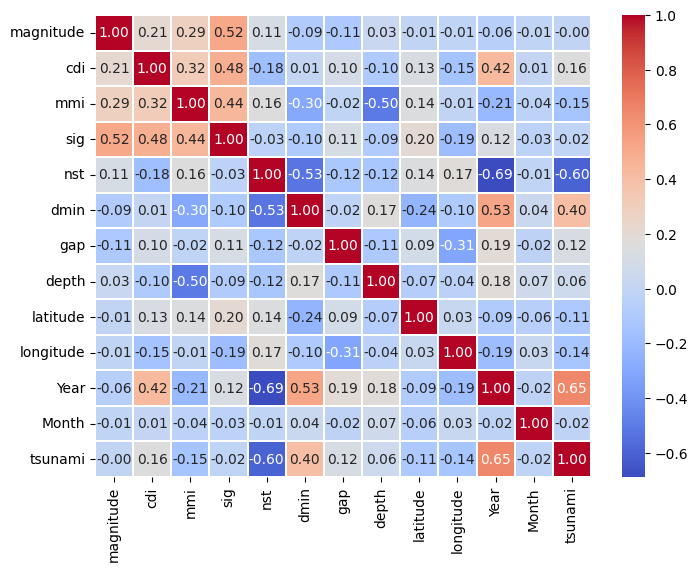

In [30]:
corr = earthquake.corr()
plt.figure(figsize=(8,6))

sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".02f", linewidths=0.1)

In [35]:

threshold = 0.8  # threshold for high correlation
corr_matrix = earthquake.corr().abs()

# Get the upper triangle of the correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
print("Potential features to drop due to high correlation:", to_drop)


Potential features to drop due to high correlation: []


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


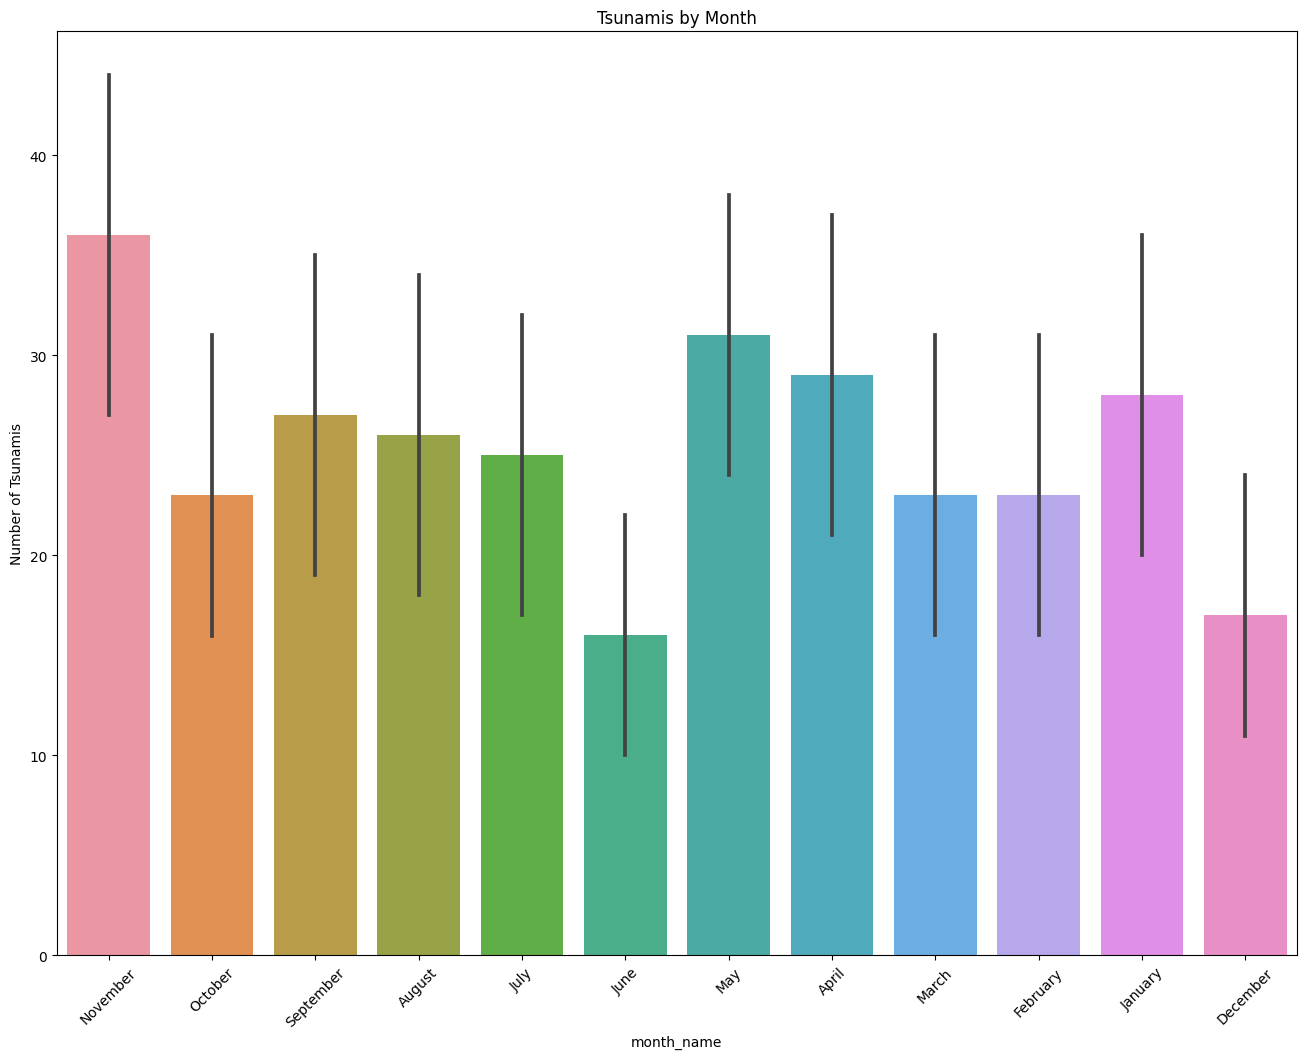

In [13]:

import calendar
earthquake['month_name'] = earthquake['Month'].apply(lambda x: calendar.month_name[x])

plt.figure(figsize=(16,12))
sns.barplot(x='month_name', y='tsunami', data=earthquake, estimator=sum)
plt.xticks(rotation=45)
plt.ylabel("Number of Tsunamis")
plt.title("Tsunamis by Month")
plt.show()


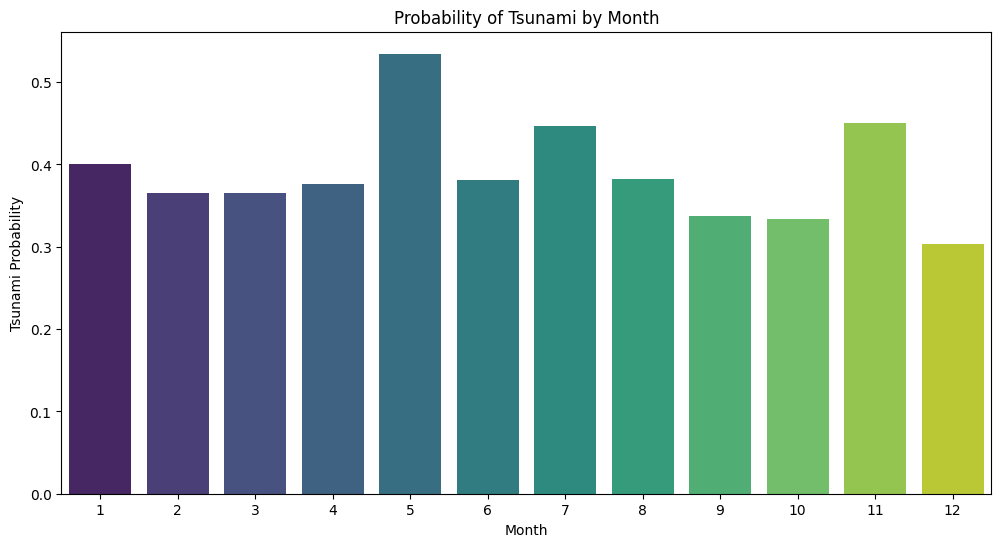

In [14]:
# Step 1: Group by month
monthly_stats = earthquake.groupby('Month').agg(
    total_earthquakes=('tsunami', 'count'),
    total_tsunamis=('tsunami', 'sum')
).reset_index()

# Step 2: Compute tsunami probability
monthly_stats['tsunami_prob'] = monthly_stats['total_tsunamis'] / monthly_stats['total_earthquakes']

# Step 3: Plot
plt.figure(figsize=(12,6))
sns.barplot(x='Month', y='tsunami_prob', data=monthly_stats, palette='viridis')
plt.ylabel('Tsunami Probability')
plt.xlabel('Month')
plt.title('Probability of Tsunami by Month')
plt.show()

In [11]:
earthquake.columns

Index(['magnitude', 'cdi', 'mmi', 'sig', 'nst', 'dmin', 'gap', 'depth',
       'latitude', 'longitude', 'Year', 'Month', 'tsunami', 'month'],
      dtype='object')

In [14]:
earthquake.head()

,magnitude,cdi,mmi,sig,nst,dmin,gap,depth,latitude,longitude,Year,Month,tsunami,month
0,0.192308,0.888889,0.750,0.052212,0.125268,0.028832,0.071130,0.016913,-9.7963,159.596,2022,11,1.0,"(10.167, 11.083]"
1,0.153846,0.444444,0.375,0.037611,0.105996,0.126260,0.142259,0.033378,-4.9559,100.738,2022,11,0.0,"(10.167, 11.083]"
2,0.192308,0.333333,0.250,0.046460,0.157388,0.177014,0.075314,0.862583,-20.0508,-178.346,2022,11,1.0,"(10.167, 11.083]"
3,0.307692,0.555556,0.500,0.080973,0.159529,0.105642,0.087866,0.051339,-19.2918,-172.129,2022,11,1.0,"(10.167, 11.083]"
4,0.038462,0.000000,0.125,0.008850,0.140257,0.283109,0.112971,0.930631,-25.5948,178.278,2022,11,1.0,"(10.167, 11.083]"


In [25]:

# X and y same as before but numeric target
X = earthquake[['magnitude', 'cdi', 'mmi', 'sig', 'nst', 'dmin', 'gap', 'depth']]
# features    
y = earthquake["tsunami"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#normalize features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train Random Forest Regressor
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train_scaled, y_train)

# Predict
y_pred = rf_reg.predict(X_test_scaled)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)

Mean Squared Error: 0.1207547770700637
Root Mean Squared Error: 0.34749788066988796


Feature Engineering

In [6]:
# Magnitude squared and cubed
earthquake['magnitude_sq'] = earthquake['magnitude'] ** 2
earthquake['magnitude_cu'] = earthquake['magnitude'] ** 3

# Magnitude bins
bins = [6.5, 7.0, 7.5, 8.0, 8.5, 9.5]
labels = ['6.5-7', '7-7.5', '7.5-8', '8-8.5', '8.5+']
earthquake['magnitude_bin'] = pd.cut(earthquake['magnitude'], bins=bins, labels=labels, include_lowest=True)



In [7]:
# Combined intensity
earthquake['intensity_sum'] = earthquake['cdi'] + earthquake['mmi']
earthquake['intensity_ratio'] = earthquake['cdi'] / earthquake['mmi'].replace(0, np.nan)


In [8]:
# Log-transform SIG
earthquake['sig_log'] = np.log(earthquake['sig'])

# Hazard-weighted magnitude
earthquake['hazard_index'] = earthquake['magnitude'] * earthquake['sig_log']


In [9]:
# Invert dmin
earthquake['inv_dmin'] = 1 / earthquake['dmin'].replace(0, np.nan)

# Low quality flag
earthquake['low_quality'] = ((earthquake['nst'] < 10) | (earthquake['gap'] > 150)).astype(int)


In [10]:
# Shallow flag
earthquake['shallow'] = (earthquake['depth'] < 70).astype(int)

# Log-transform depth
earthquake['depth_log'] = np.log(earthquake['depth'])

# Magnitude / depth ratio
earthquake['mag_depth_ratio'] = earthquake['magnitude'] / earthquake['depth'].replace(0, np.nan)


In [11]:
# Approximate ocean proximity (example: if latitude < -60 or > 60, flag as ocean-adjacent)
# You could improve with actual coastline data
earthquake['ocean_flag'] = (((earthquake['latitude'] > -60) & (earthquake['latitude'] < 60)) & 
                            ((earthquake['longitude'] > -180) & (earthquake['longitude'] < 180))).astype(int)

# Region binning example (rough continental zones)
def region_bin(lat, lon):
    if lat > 0 and lon < 0:
        return 'NW'
    elif lat > 0 and lon > 0:
        return 'NE'
    elif lat < 0 and lon < 0:
        return 'SW'
    else:
        return 'SE'

earthquake['region'] = earthquake.apply(lambda row: region_bin(row['latitude'], row['longitude']), axis=1)


In [12]:
# Time since first earthquake in dataset
earthquake['years_since_start'] = earthquake['Year'] - earthquake['Year'].min()

# Cyclical month features
earthquake['month_sin'] = np.sin(2 * np.pi * earthquake['Month'] / 12)
earthquake['month_cos'] = np.cos(2 * np.pi * earthquake['Month'] / 12)


In [13]:
# Interaction terms
earthquake['mag_depth_ocean'] = earthquake['magnitude'] * earthquake['depth'] * earthquake['ocean_flag']
earthquake['hazard_ocean'] = earthquake['hazard_index'] * earthquake['ocean_flag']


In [14]:
# Features (drop target)
X = earthquake.drop("tsunami", axis=1)

# Target
y = earthquake["tsunami"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)


In [15]:
# Identify numerical columns
num_cols = X_train.select_dtypes(include=np.number).columns.tolist()

scaler = MinMaxScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])


In [16]:
# Convert categorical columns to one-hot numeric columns
cat_cols = ['magnitude_bin', 'region']
X_train = pd.get_dummies(X_train, columns=cat_cols)
X_test = pd.get_dummies(X_test, columns=cat_cols)

# Align columns to make sure train/test have the same features
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)


In [17]:
# Check which columns have NaNs
print(X_train.isna().sum())


magnitude                0
cdi                      0
mmi                      0
sig                      0
nst                      0
dmin                     0
gap                      0
depth                    0
latitude                 0
longitude                0
Year                     0
Month                    0
magnitude_sq             0
magnitude_cu             0
intensity_sum            0
intensity_ratio          0
sig_log                  0
hazard_index             0
inv_dmin               282
low_quality              0
shallow                  0
depth_log                0
mag_depth_ratio          0
ocean_flag               0
years_since_start        0
month_sin                0
month_cos                0
mag_depth_ocean          0
hazard_ocean             0
magnitude_bin_6.5-7      0
magnitude_bin_7-7.5      0
magnitude_bin_7.5-8      0
magnitude_bin_8-8.5      0
magnitude_bin_8.5+       0
region_NE                0
region_NW                0
region_SE                0
r

In [18]:
# Fill numerical NaNs with median
num_cols = X_train.select_dtypes(include=np.number).columns
X_train[num_cols] = X_train[num_cols].fillna(X_train[num_cols].median())
X_test[num_cols] = X_test[num_cols].fillna(X_train[num_cols].median())  # use train median


In [19]:
X_train.describe()

,magnitude,cdi,mmi,sig,nst,dmin,gap,depth,latitude,longitude,...,low_quality,shallow,depth_log,mag_depth_ratio,ocean_flag,years_since_start,month_sin,month_cos,mag_depth_ocean,hazard_ocean
count,547.000000,547.000000,547.000000,547.000000,547.000000,547.000000,547.000000,547.000000,547.000000,547.000000,...,547.000000,547.000000,547.000000,547.000000,547.000000,547.000000,547.000000,547.000000,547.000000,547.000000
mean,0.171889,0.479586,0.622943,0.099061,0.244035,0.072136,0.108418,0.103930,0.505281,0.648453,...,0.475320,0.809872,0.442883,0.140387,0.979890,0.541656,0.477002,0.551472,0.094505,0.655257
std,0.178592,0.356357,0.182735,0.146577,0.265957,0.124973,0.106938,0.202651,0.208581,0.325798,...,0.499848,0.392761,0.204075,0.117718,0.140504,0.292638,0.361616,0.341332,0.179633,0.114990
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.038462,0.000000,0.500000,0.018142,0.000000,0.000000,0.061715,0.015417,0.369809,0.301558,...,0.000000,1.000000,0.284974,0.060147,1.000000,0.285714,0.066987,0.250000,0.015945,0.614376
50%,0.115385,0.555556,0.625000,0.046460,0.148822,0.000000,0.086611,0.033378,0.459095,0.801481,...,0.000000,1.000000,0.403541,0.112112,1.000000,0.571429,0.500000,0.500000,0.033202,0.646061
75%,0.230769,0.777778,0.750000,0.117478,0.475375,0.097881,0.125941,0.063313,0.666152,0.911753,...,1.000000,1.000000,0.510116,0.214328,1.000000,0.809524,0.750000,0.933013,0.058950,0.697174
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [20]:
rf_model = RandomForestClassifier(
    n_estimators=200, random_state=42, max_depth=10, class_weight='balanced'
)
rf_model.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=200,
                       random_state=42)

Accuracy: 0.9276595744680851


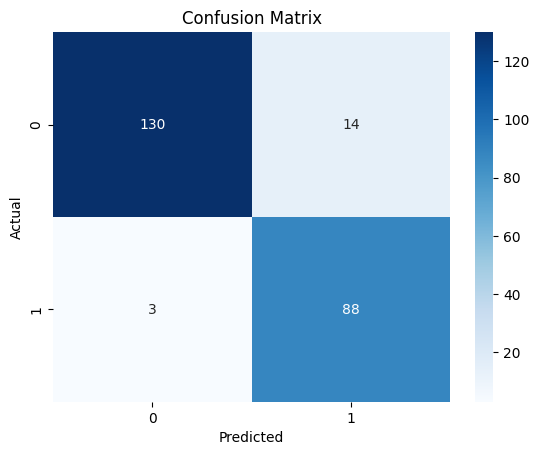

In [21]:
# Predictions
y_pred = rf_model.predict(X_test)

# Accuracy
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [22]:
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=10, scoring='accuracy')
print("CV Accuracy Scores:", cv_scores)
print("Average CV Accuracy:", cv_scores.mean())


CV Accuracy Scores: [0.89090909 0.92727273 0.83636364 0.85454545 0.85454545 0.87272727
 0.8        0.88888889 0.88888889 1.        ]
Average CV Accuracy: 0.8814141414141414


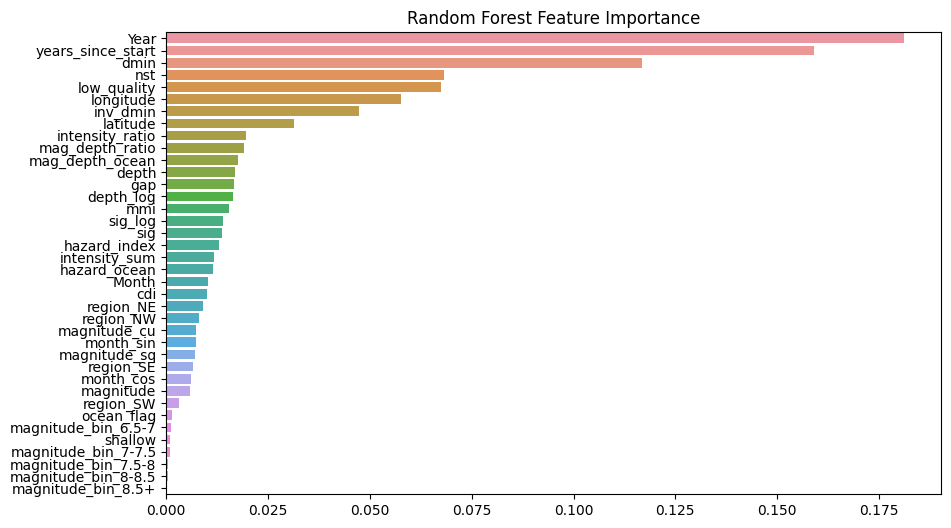

In [56]:
importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=importances.values, y=importances.index)
plt.title("Random Forest Feature Importance")
plt.show()


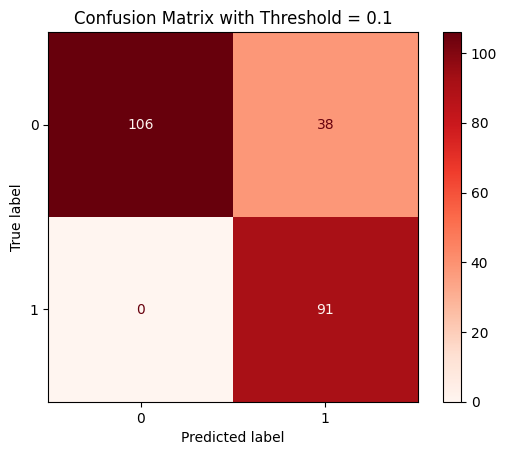

In [25]:
# Predicted probabilities for class 1
y_prob = rf_model.predict_proba(X_test)[:,1]

# Lower threshold to increase recall
threshold = 0.1
y_pred_thresh = (y_prob >= threshold).astype(int)

# Confusion matrix for threshold-adjusted predictions
cm_thresh = confusion_matrix(y_test, y_pred_thresh)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_thresh, display_labels=[0, 1])
disp.plot(cmap='Reds', values_format='d')
plt.title(f"Confusion Matrix with Threshold = {threshold}")
plt.show()


In [26]:
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score





precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
# Assuming y_test and y_pred are your true and predicted labels
f1 = f1_score(y_test, y_pred)

print("F1-score:", f1)
print("Precision:", precision)
print("Recall:", recall)


F1-score: 0.9119170984455958
Precision: 0.8627450980392157
Recall: 0.967032967032967


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


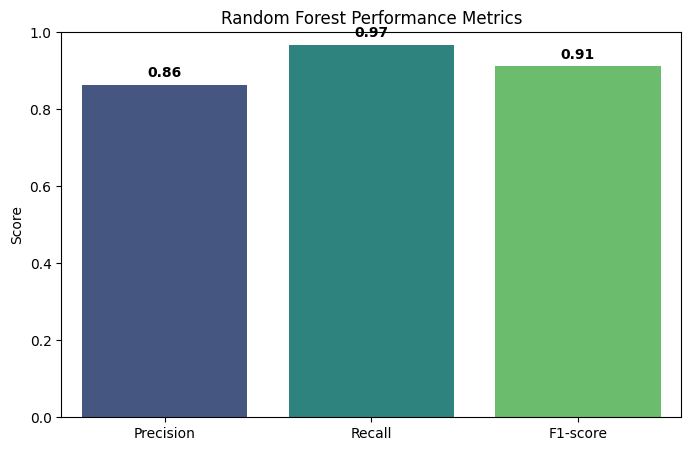

In [27]:
metrics = {
    "Precision": precision,
    "Recall": recall,
    "F1-score": f1
}

# Plot
plt.figure(figsize=(8,5))
sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette="viridis")
plt.ylim(0, 1)  # scale from 0 to 1
plt.title("Random Forest Performance Metrics")
plt.ylabel("Score")
for i, v in enumerate(metrics.values()):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontweight='bold')
plt.show()
